# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.668177,True,6.970205
1,-0.291871,True,4.857942
2,0.046020,True,5.387203
3,-0.601034,False,-2.936236
4,-2.042230,False,-3.920646
...,...,...,...
995,-1.561052,False,-1.215025
996,-0.290057,False,-2.142960
997,-1.156101,False,-0.370745
998,-0.732807,False,-1.922964


<Axes: xlabel='v0'>

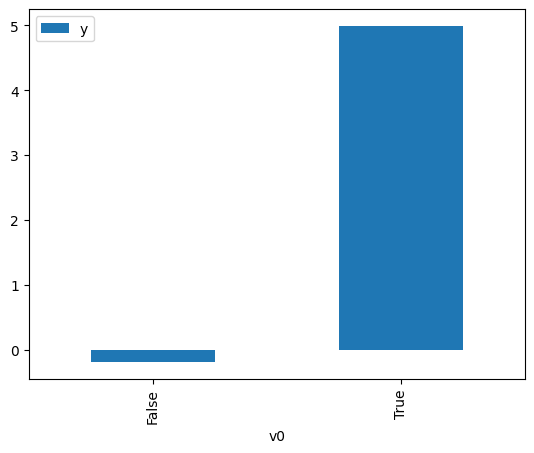

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

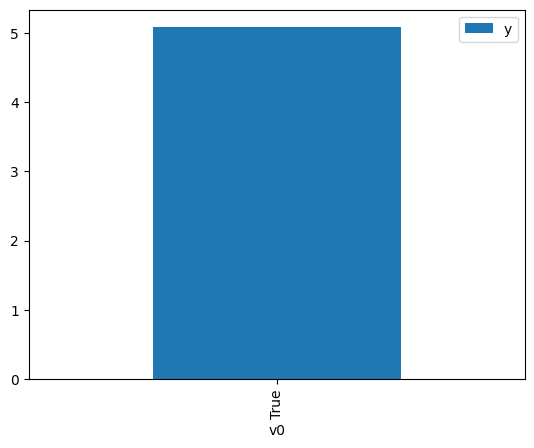

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.639780,False,-4.250883,0.969588,1.031366
1,-0.442939,False,-1.107574,0.699270,1.430063
2,1.246396,False,1.965423,0.054590,18.318315
3,-0.204212,False,-0.284739,0.579710,1.725000
4,0.535547,False,0.579688,0.214719,4.657247
...,...,...,...,...,...
995,-1.457028,False,-2.773123,0.955308,1.046783
996,-0.023986,False,0.178944,0.481838,2.075385
997,0.070553,False,1.420155,0.430578,2.322458
998,-1.122728,False,-1.477888,0.911406,1.097206


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.094421,True,4.997059,0.479660,2.084810
1,-0.211197,True,4.675631,0.416572,2.400548
2,0.906771,True,8.216713,0.891756,1.121384
3,-0.597175,True,2.900050,0.234831,4.258376
4,0.110182,True,4.737032,0.590537,1.693375
...,...,...,...,...,...
995,-0.582541,True,5.514049,0.240632,4.155715
996,1.339761,True,6.669533,0.955041,1.047075
997,0.448267,True,6.154305,0.751341,1.330953
998,1.610851,True,8.743860,0.974644,1.026016


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.059e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):                        0.00
Time:                        09:22:56   Log-Likelihood:                         -1430.7
No. Observations:                1000   AIC:                                      2865.
Df Residuals:                     998   BIC:                                      2875.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9617      0.035     56.286      0.000       1.893       2.030
x2             4.9829      0.049    101.379      0.000       4.886       5.079
==============================================================================
Omnibus:                        0.576   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.750   Jarque-Bera (JB):                0.662
Skew:                          -0.026   Prob(JB):                        0.718
Kurtosis:                       2.885   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""